<a href="https://colab.research.google.com/github/NgPcAnhh/Data/blob/master/Stock_price_prediction(Mix_Close_Volume).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#/content/drive/MyDrive/dataset/model_saving => cho lưu các model được huấn luyện
#/content/drive/MyDrive/dataset/data_raw => cho các dữ liệu mã cổ phiếu có sẵn
#/content/drive/MyDrive/dataset/test => cho thử nghiệm

Mounted at /content/drive


In [21]:
import pandas as pd

# Đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/data_raw/FPT (1).csv')

# Xóa cột "Ticker" từ từng DataFrame
df = df.drop(columns=["Ticker"])

df

,Date/Time,Open,High,Low,Close,Volume
0,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410
1,12/25/2018 9:16,30.81,30.81,30.81,30.81,190
2,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120
3,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120
4,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500
...,...,...,...,...,...,...
97401,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470
97402,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820
97403,12/22/2020 14:26,58.20,58.20,58.20,58.20,500
97404,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500


In [22]:
df.columns

Index(['Date/Time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [23]:
#định dạng cấu trúc thời gian
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M')
df.index = df['Date/Time']

In [24]:
df.shape

(97406, 6)

In [25]:
df.head()

,Date/Time,Open,High,Low,Close,Volume
Date/Time,,,,,,
2018-12-25 09:15:00,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
2018-12-25 09:16:00,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2018-12-25 09:17:00,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
2018-12-25 09:18:00,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
2018-12-25 09:19:00,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97406 entries, 2018-12-25 09:15:00 to 2020-12-22 14:46:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date/Time  97406 non-null  datetime64[ns]
 1   Open       97406 non-null  float64       
 2   High       97406 non-null  float64       
 3   Low        97406 non-null  float64       
 4   Close      97406 non-null  float64       
 5   Volume     97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 5.2 MB


In [27]:
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,97406,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04
mean,2020-01-21 05:08:51.739112192,45.071630,45.090138,45.051430,45.071631,8.044173e+03
min,2018-12-25 09:15:00,30.250000,30.250000,30.220000,30.250000,1.000000e+01
25%,2019-08-06 11:06:15,39.740000,39.740000,39.700000,39.740000,7.500000e+02
50%,2020-01-31 10:37:30,46.950000,46.950000,46.950000,46.950000,2.960000e+03
75%,2020-07-14 09:54:45,49.200000,49.250000,49.170000,49.200000,8.960000e+03
max,2020-12-22 14:46:00,58.400000,58.500000,58.400000,58.400000,1.255930e+06
std,NaN,6.359803,6.364950,6.354245,6.359799,1.753203e+04


Tiền xử lý dữ liệu

In [28]:
# Lấy cột 'Date/Time' và 'Close' từ DataFrame gốc
df1 = df[['Date/Time','Close','Volume']].copy()

# Đặt 'Date/Time' làm index
df1.set_index('Date/Time', inplace=True)

numerical_data = df1.values  # Chỉ lấy giá trị số, bỏ qua index (Date/Time)

# Hiển thị DataFrame kết quả
df1

,Close,Volume
Date/Time,,
2018-12-25 09:15:00,30.89,35410
2018-12-25 09:16:00,30.81,190
2018-12-25 09:17:00,30.74,1120
2018-12-25 09:18:00,30.74,2120
2018-12-25 09:19:00,30.74,22500
...,...,...
2020-12-22 14:24:00,58.20,27470
2020-12-22 14:25:00,58.20,14820
2020-12-22 14:26:00,58.20,500


<ipython-input-12-e37cef57fffd>:31: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ohlc['Date_num'] = mdates.date2num(ohlc['Date/Time'].dt.to_pydatetime())


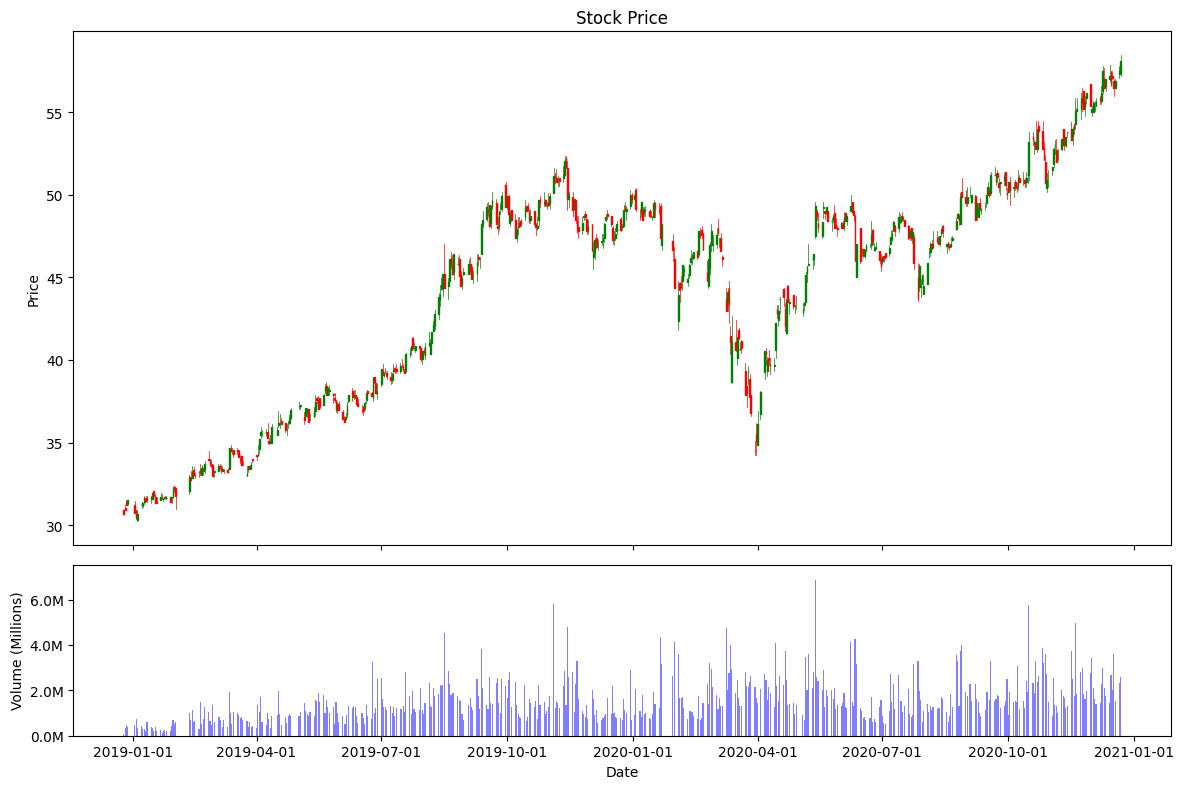

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Check if 'Date/Time' is already the index
if 'Date/Time' not in df.columns:
    # If 'Date/Time' is the index, reset it to be a column
    df = df.reset_index()

# Convert Date/Time column to datetime if it's not already
if df['Date/Time'].dtype != 'datetime64[ns]':
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Set Date/Time as index
df.set_index('Date/Time', inplace=True)

# Create a new DataFrame with OHLC data
ohlc = df[['Open', 'High', 'Low', 'Close']].resample('D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()  # Drop rows with NaN values

# Reset index to get Date as a column for plotting
ohlc.reset_index(inplace=True)

# Convert Date to number for plotting
ohlc['Date_num'] = mdates.date2num(ohlc['Date/Time'].dt.to_pydatetime())

# Create the main figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot candlestick chart
candlestick_ohlc(ax1, ohlc[['Date_num', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='g', colordown='r')

# Set x-axis format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Set labels and title for candlestick chart
ax1.set_ylabel('Price')
ax1.set_title('Stock Price')

# Plot volume bar chart
volume = df['Volume'].resample('D').sum()
ax2.bar(volume.index, volume.values, color='b', alpha=0.5)

# Set y-axis limits for volume chart
max_volume = volume.max()
ax2.set_ylim(0, max_volume * 1.1)  # Increase upper limit by 10%

# Format y-axis labels to millions
def millions(x, pos):
    return f'{x/1e6:.1f}M'

ax2.yaxis.set_major_formatter(FuncFormatter(millions))

# Set labels for volume chart
ax2.set_ylabel('Volume (Millions)')
ax2.set_xlabel('Date')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [13]:
#chia tập dữ liệu
data = df1.values
train_data = data[:80000]
test_data = data[80000:]

In [14]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)
sc_train

array([[2.27353464e-02, 2.81865087e-02],
       [1.98934281e-02, 1.43321231e-04],
       [1.74067496e-02, 8.83814256e-04],
       ...,
       [9.92895204e-01, 3.90152239e-04],
       [9.89342806e-01, 1.98261036e-03],
       [9.89342806e-01, 8.88591630e-03]])

In [18]:
# gắn giá trị và list
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i-50:i, :])  # Lấy 50 giá trị liên tục của cả volume và close
    y_train.append(sc_train[i, 0])  # Lấy ra giá đóng cửa ngày hôm sau
# khởi tạo ma trận
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

Xây dựng và huấn luyện mô

In [16]:
# Xây dựng mô hình
model = Sequential()  # Tạo lớp mạng cho dữ liệu đầu vào

# 2 lớp LSTM
model.add(LSTM(units=128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))  # Loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1))  # Output đầu ra 1 chiều

# Đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Cập nhật đường dẫn tệp lưu mô hình với phần mở rộng .keras
save_model = "/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

In [30]:
# tiếp tục load model epoch 33
# dữ liệu dài, chia 2 ngày nên phải có phần code để lưu lại checkpoint
from tensorflow.keras.models import load_model

# Đường dẫn đến mô hình đã lưu
save_model = "/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras"

# Tải lại mô hình từ checkpoint đã lưu
model = load_model(save_model)
print("Model loaded from Google Drive")

Model loaded from Google Drive


In [ ]:
# load tiếp checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn để lưu mô hình
save_model = "/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras"

# Định nghĩa lại checkpoint callback để tiếp tục lưu mô hình tốt nhất
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Tiếp tục huấn luyện mô hình
model.fit(x_train, y_train, initial_epoch=32, epochs=100, batch_size=50, verbose=2, callbacks=[best_model]) # sửa lại epoche sao cho phù hợp

Kiểm tra và đánh giá mô hình

In [32]:
# Tải mô hình đã lưu hay tái sử dụng mô hình
final_model = load_model("/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras")

# Dự đoán giá đóng cửa trên tập đã train
y_train_predict = final_model.predict(x_train)

# Thêm một cột volume giả vào y_train để khớp hình dạng ban đầu
y_train_combined = np.hstack((y_train, np.zeros((y_train.shape[0], 1))))

# Đảo ngược chuẩn hóa
y_train_inverse = sc.inverse_transform(y_train_combined)[:, 0].reshape(-1, 1)  # Chỉ giữ lại giá trị 'close'

# Tương tự cho y_train_predict
# Thêm một cột volume giả vào y_train_predict để khớp hình dạng ban đầu
y_train_predict_combined = np.hstack((y_train_predict, np.zeros((y_train_predict.shape[0], 1))))

# Đảo ngược chuẩn hóa
y_train_predict_inverse = sc.inverse_transform(y_train_predict_combined)[:, 0].reshape(-1, 1)
#######################################################################################################
# Xử lý dữ liệu test
test = df1[len(train_data)-50:].values
sc_test = sc.transform(test)

x_test = []
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i-50:i, :])  # Lấy 50 giá trị liên tục của cả volume và close
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Dữ liệu test
y_test = data[80000:]  # Giá thực
y_test_predict = final_model.predict(x_test)

# Thêm một cột volume giả vào y_test_predict để khớp hình dạng ban đầu
y_test_predict_combined = np.hstack((y_test_predict, np.zeros((y_test_predict.shape[0], 1))))

# Đảo ngược chuẩn hóa
y_test_predict_inverse = sc.inverse_transform(y_test_predict_combined)[:, 0].reshape(-1, 1)  # Chỉ giữ lại giá trị 'close'


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 94s 37ms/step
544/544 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step


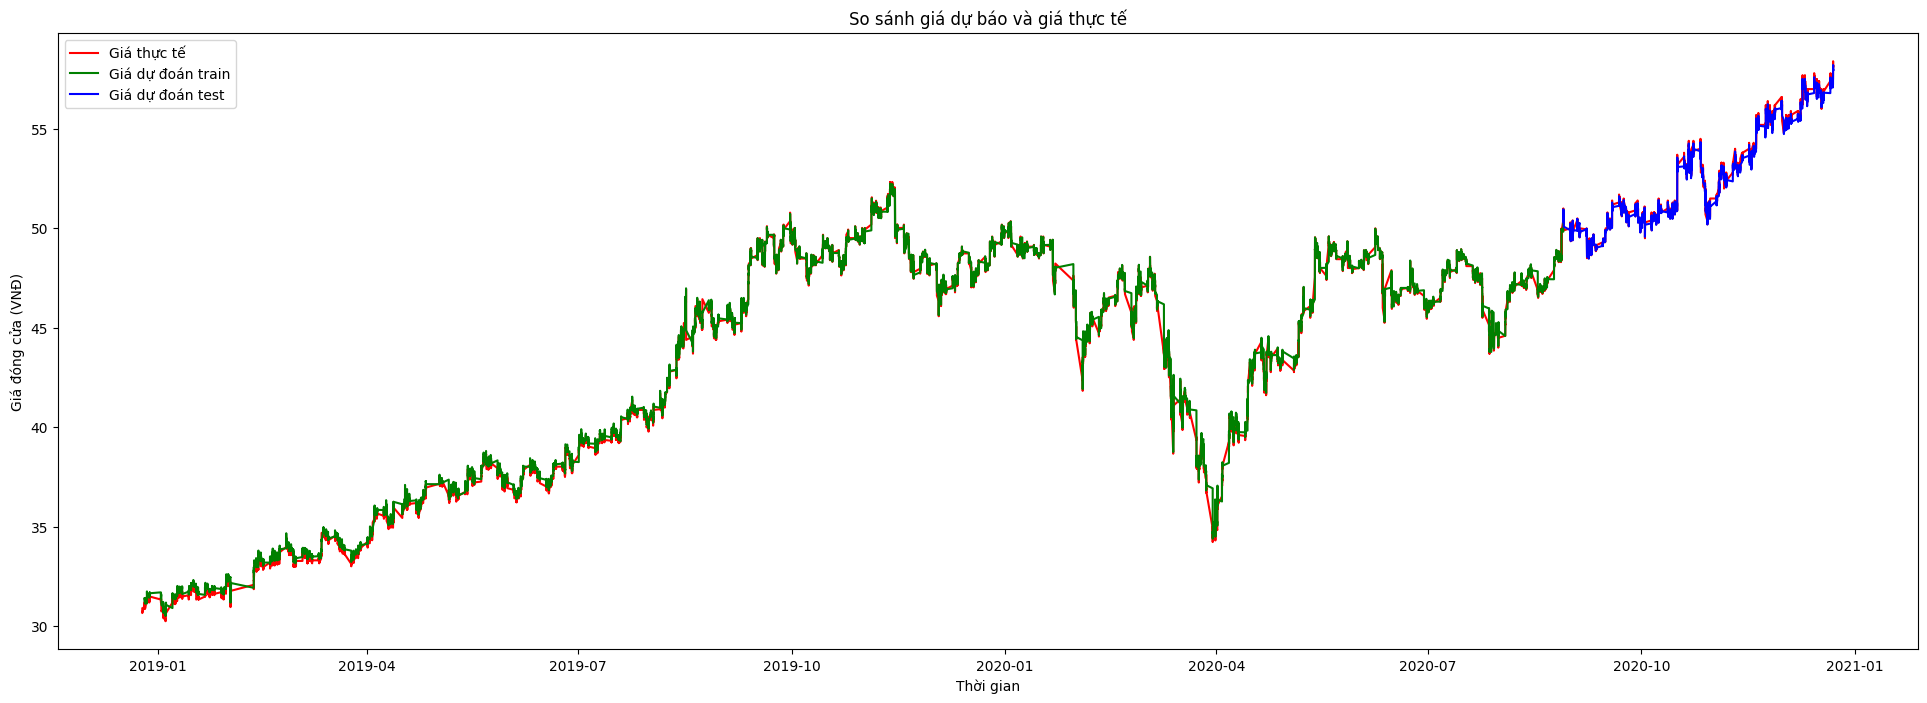

In [33]:
# Tạo các DataFrame chứa dữ liệu train và test
train_data1 = df1[50:80000].copy()  # Bắt đầu từ dòng thứ 50
test_data1 = df1[80000:].copy()

# Điều chỉnh kích thước của y_train_predict_inverse và y_test_predict_inverse
train_data1['Dự đoán'] = y_train_predict_inverse
test_data1['Dự đoán'] = y_test_predict_inverse[:len(test_data1)]

# Vẽ biểu đồ
plt.figure(figsize=(24, 8))
plt.plot(df1['Close'], label='Giá thực tế', color='red')  # Đường giá thực
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')  # Đường giá dự báo train
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')  # Đường giá dự báo test

# Đặt tên biểu đồ và các trục
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')

# Thêm chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

In [34]:
#r bình phương
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mape
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9994431244725833
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.0037581916569461205
Phần trăm sai số tuyệt đối trung bình tập train: 3626527756.397608


In [35]:
train_data1

,Close,Volume,Dự đoán
Date/Time,,,
2018-12-26 10:19:00,31.15,100,31.404357
2018-12-26 10:20:00,31.11,9000,31.402635
2018-12-26 10:21:00,31.15,90,31.362615
2018-12-26 10:22:00,31.11,3700,31.407477
2018-12-26 10:23:00,31.15,1780,31.360591
...,...,...,...
2020-08-28 09:25:00,50.90,40900,50.809333
2020-08-28 09:26:00,50.90,90910,50.847649
2020-08-28 09:27:00,50.90,69950,50.861333


In [36]:
# Giả sử y_test đã được định nghĩa và chứa giá trị thực tế
y_test_close = y_test[:,0]  # Giả sử y_test có hai cột, cột 0 là close, cột 1 là volume

# Cắt bớt y_test_close cho phù hợp với kích thước của y_test_predict_inverse
y_test_close = y_test_close[:len(y_test_predict_inverse)]

# R²
r2 = r2_score(y_test_close, y_test_predict_inverse)
print('Độ phù hợp tập test:', r2)

# MAE
mae = mean_absolute_error(y_test_close, y_test_predict_inverse)
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mae)

# MAPE
mape = mean_absolute_percentage_error(y_test_close, y_test_predict_inverse)
print('Phần trăm sai số tuyệt đối trung bình tập test:', mape)

Độ phù hợp tập test: 0.9977390156538106
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.09626543956365932
Phần trăm sai số tuyệt đối trung bình tập test: 0.001783510307010238


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


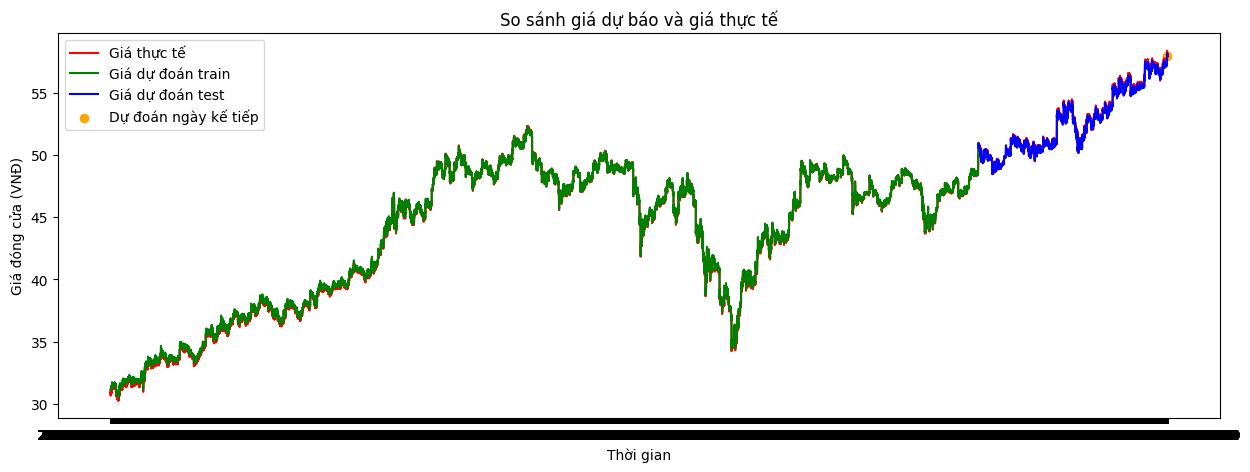

In [37]:
# Chuyển đổi cột 'Date/Time' thành định dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%Y-%m-%d %H-%M')

# Gọi thêm ngày tiếp theo để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Lấy 50 giá trị gần nhất của cả 'Close' và 'Volume'
last_50_days = df[['Close', 'Volume']].iloc[-50:].values

# Chuẩn hóa 50 giá trị gần nhất
last_50_days_normalized = sc.transform(last_50_days)

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.reshape(last_50_days_normalized, (1, last_50_days_normalized.shape[0], last_50_days_normalized.shape[1]))
final_model = load_model("/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras")
y_next_predict = final_model.predict(x_next)

# Đảo ngược chuẩn hóa để lấy giá trị dự đoán thực tế
y_next_predict = sc.inverse_transform(np.hstack((y_next_predict, np.zeros((y_next_predict.shape[0], 1)))))[:, 0]

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Close': [y_next_predict[0]]}, index=[next_date])
df1 = pd.concat([df1, df_next])

plt.figure(figsize=(15, 5))

# Chuyển đổi chỉ số thành chuỗi để vẽ biểu đồ
plt.plot(df1.index.astype(str), df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index.astype(str), train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index.astype(str), test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

# Kiểm tra nếu next_date không phải là NaT trước khi sử dụng strftime
if not pd.isna(next_date):
    plt.scatter([next_date.strftime('%Y-%m-%d %H-%M')], [y_next_predict[0]], color='orange', label='Dự đoán ngày kế tiếp')

plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


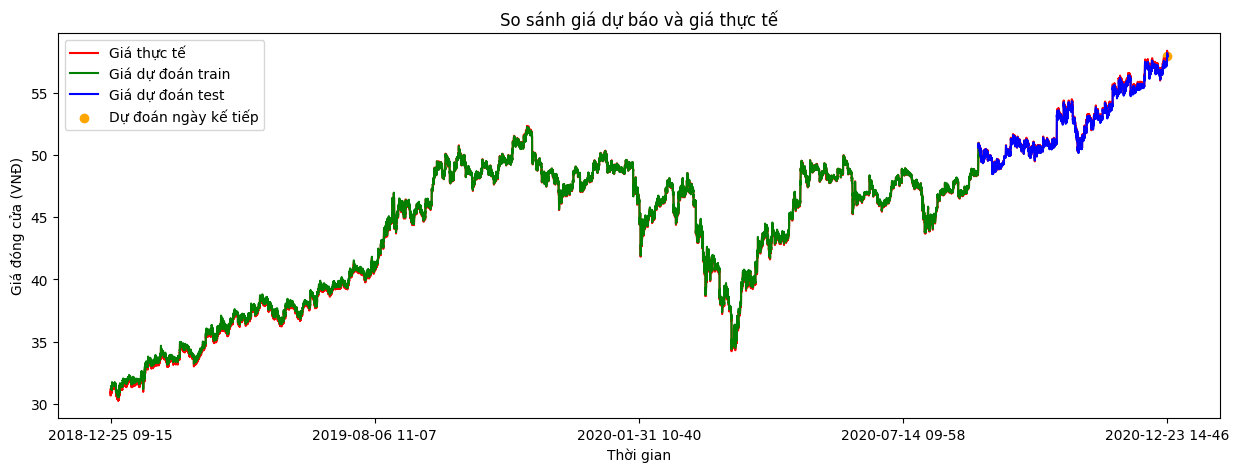

In [43]:
# cho thời gian bé để biểu đồ render nhanh hơn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Chuyển đổi cột 'Date/Time' thành định dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%Y-%m-%d %H-%M')

# Gọi thêm ngày tiếp theo để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Lấy 50 giá trị gần nhất của cả 'Close' và 'Volume' và chuẩn hóa
last_50_days_normalized = sc.transform(df[['Close', 'Volume']].iloc[-50:].values)

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.reshape(last_50_days_normalized, (1, last_50_days_normalized.shape[0], last_50_days_normalized.shape[1]))
final_model = load_model("/content/drive/MyDrive/dataset/model_saving/FPTstocks_prediction_shortterm_v2.keras")
y_next_predict = final_model.predict(x_next)

# Đảo ngược chuẩn hóa để lấy giá trị dự đoán thực tế
y_next_predict = sc.inverse_transform(np.hstack((y_next_predict, np.zeros((y_next_predict.shape[0], 1)))))[:, 0]

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df1 = pd.concat([df1, pd.DataFrame({'Close': [y_next_predict[0]]}, index=[next_date])])

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(df1.index.astype(str), df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index.astype(str), train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index.astype(str), test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

# Chỉ lấy một số mốc thời gian để hiển thị trên trục X
num_ticks = 5
plt.xticks(np.linspace(0, len(df1.index) - 1, num_ticks).astype(int), df1.index[np.linspace(0, len(df1.index) - 1, num_ticks).astype(int)].strftime('%Y-%m-%d %H-%M'))

# Kiểm tra nếu next_date không phải là NaT trước khi sử dụng strftime
if not pd.isna(next_date):
    plt.scatter([next_date.strftime('%Y-%m-%d %H-%M')], [y_next_predict[0]], color='orange', label='Dự đoán ngày kế tiếp')

plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [39]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({
    'Date/Time': [next_date],
    'Giá dự đoán': [y_next_predict[0]],
    'Giá ngày trước': [actual_closing_price],
    'Biến động giá': [y_next_predict[0] - actual_closing_price]
})

# In ra bảng so sánh
print(comparison_df)


            Date/Time  Giá dự đoán  Giá ngày trước  Biến động giá
0 2020-12-23 14:46:00     57.94122            58.1       -0.15878
